# 0. Imports

In [1]:
from pathlib import Path
ROOT_DIR = Path().resolve()

# 1. Load and investigate setup

leveraging `MIKEIO` and its pfs reading capabilities

In [2]:
import mikeio

# specify simulation setup file 
simfile = ROOT_DIR / "mike_autocal/tests/data/simulation_data_sns/simulation/sns_base.m21fm"
# read with mikeio and display some information
pfs = mikeio.read_pfs(simfile)
pfs.FemEngineHD.TIME

Touched = 1
start_time = 2022, 1, 1, 0, 0, 0
time_step_interval = 600.0
number_of_time_steps = 500

# 2. Run simulation with simple logging

* simplest version with basic logging of runtime information (from stdout)
* without utilizing observations
* introducting `RunTimeEvaluation` (RTE). 
    * Evaluates and generates logs with `TensorBoards` SummaryWriter (default is a timestamped directory like logs/simulation_YYYYMMDD_HHMMSS)
    * Logs can be found in `/teamspace/studios/this_studio/logs` and accessed via Tensorboard in real time.
    * frequency is the only argument that can be used in the RTE when no observation (SimObsPairs) are specified.
    * Logs will solely contain runtime information   
* introducing simulation `Launcher`

In [ ]:
from mike_autocal.mikesimulation import RunTimeEvaluation, Launcher


rte = RunTimeEvaluation(frequency=10) # frequency of logging will be every 10 timesteps by default  

launcher = Launcher(
    simfile = simfile,                  # path to simulation setup file
    use_gpu=True,           # use GPU if available
    runtimeevaluation=rte,  # Use an empty RunTimeEvaluation object
    n_cores = 1)
    
launcher.execute_simulation()

Processing: 100%|██████████| 500/500 [00:13<00:00, 36.22step/s]


<mark>tensorboard shows timing but not e.g. 50 outputs (one every 10 timesteps with 500 timesteps). Are we ignoring some in the beginning? E.g. with timestep 1 we will have timestep 332 and 500 and one in the beginning. Progress bar also just shows 0%, 33%, 68%, 100%. Simulations can also overlap (if run in the same minute?). This seems independent of the frequency i set in runtimeevaluation</mark>

<Axes: >

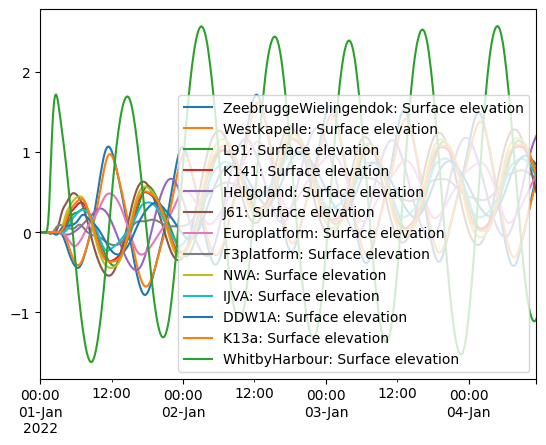

In [13]:
# visualize some results
out_area = str(simfile) + " - Result Files/Area.dfsu"
out_waterlevel = str(simfile) + " - Result Files/waterlevels.dfs0"

df_wl =  mikeio.read(out_waterlevel).to_dataframe()
df_wl.plot()


# 